# Importation des données

In [31]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [7]:
data = pd.read_csv('data/data.csv.gz', compression='gzip')
labels = pd.read_csv('data/labels.csv')

data = data.drop(columns=['Unnamed: 0'])
labels = labels.drop(columns=['Unnamed: 0'])

# LDA

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [12]:
y_train = y_train.values.ravel()  # Convertir en (n_samples,)


lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.9876
              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        60
        COAD       1.00      0.94      0.97        16
        KIRC       1.00      1.00      1.00        30
        LUAD       0.96      0.96      0.96        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.98      0.98       161
weighted avg       0.99      0.99      0.99       161



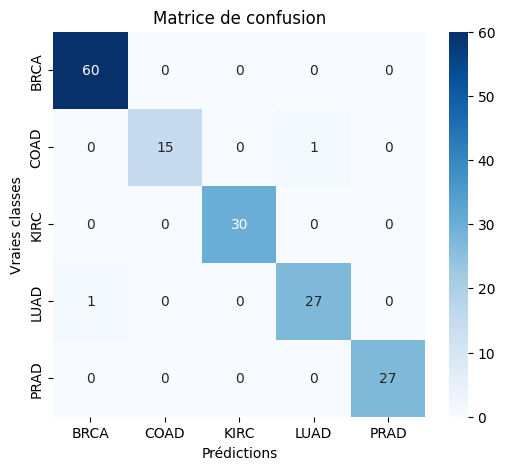

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage avec seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lda.classes_, yticklabels=lda.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()


Shape de y_test_flat : (161,)
Shape de X_lda_test : (161, 2)


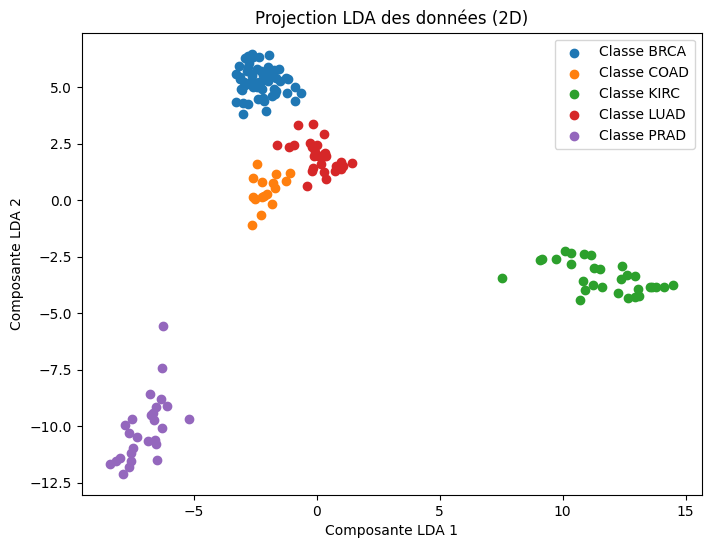

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# Appliquer LDA avec 2 composantes
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_train, y_train)  # Transformation sur X_train

# Appliquer la transformation LDA sur X_test (pour la visualisation)
X_lda_test = lda.transform(X_test)  # Transforme X_test selon la même LDA que X_train

# Aplatir y_test
y_test_flat = y_test.values.ravel()  # Convertir en numpy array et aplatir

# Vérification des formes (facultatif)
print(f"Shape de y_test_flat : {y_test_flat.shape}")
print(f"Shape de X_lda_test : {X_lda_test.shape}")

# Affichage
plt.figure(figsize=(8, 6))
for label in np.unique(y_test_flat):
    plt.scatter(X_lda_test[y_test_flat == label, 0], X_lda_test[y_test_flat == label, 1], label=f'Classe {label}')

plt.xlabel("Composante LDA 1")
plt.ylabel("Composante LDA 2")
plt.legend()
plt.title("Projection LDA des données (2D)")
plt.show()


Les classes sont : <br>
    - bien séparées (moins pour LUAD et COAD) <br>
    - très bien dispersées pour PRAD et KIRC surtout <br>
Mais ça coûte super cher en calcul ! On le rappelle mais le dataframe complet possède près de 21 000 variables ! <br>
<br>
On va donc faire cette LDA sur les composantes principales issues de l'ACP du jeu de données filtrés.

# LDA FINALE

## Filtrage des axes + standardisation (cf CAH et KMEANS)

In [25]:
# Calculer la variance des colonnes
variances = data.var(axis=0)

# Filtrer les gènes avec un seuil 
df_filtré = data.loc[:, variances > 3]

df_filtré.info()

df = pd.DataFrame(df_filtré)  

# Appliquer le StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Convertir en DataFrame si besoin
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)

# Vérification : moyenne proche de 0 et écart-type proche de 1
print("Moyennes après scaling:", df_scaled.mean().mean())  # Devrait être proche de 0
print("Écart-types après scaling:", df_scaled.std().mean())  # Devrait être proche de 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 3531 entries, gene_18 to gene_20529
dtypes: float64(3531)
memory usage: 21.6 MB
Moyennes après scaling: -3.7948854334468506e-18
Écart-types après scaling: 1.0006248048094746


## ACP sur df_scaled

In [29]:
# 1. Réalisation de l'ACP
pca = PCA(n_components=100)
pca.fit(df_filtré)
components = pca.fit_transform(df_filtré)

## LDA sur les 100 premières composantes principales

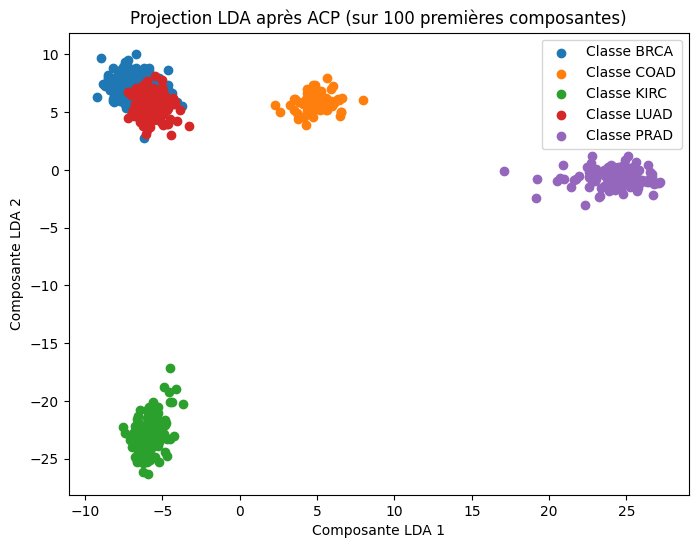

In [30]:
# 2. Application de l'LDA sur les 100 premières composantes principales
y = labels['Class']
lda = LinearDiscriminantAnalysis(n_components=2)  # Réduction à 2 dimensions pour la visualisation
X_lda = lda.fit_transform(components, y)  # LDA sur les 100 premières composantes de PCA

# 3. Visualisation des résultats LDA
plt.figure(figsize=(8, 6))
for label in np.unique(y):  # y étant vos labels
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], label=f'Classe {label}')

plt.xlabel("Composante LDA 1")
plt.ylabel("Composante LDA 2")
plt.legend()
plt.title("Projection LDA après ACP (sur 100 premières composantes)")
plt.show()


In [34]:

# 1. Réalisation de l'ACP sur les données
pca = PCA(n_components=100)  # Réduction aux 100 premières composantes
X_pca = pca.fit_transform(df_filtré)  # df_filtré : vos données sans les labels

# 2. Création de l'objet LDA
lda = LinearDiscriminantAnalysis(n_components=4)  # il y a 4 composantes LDA

# 3. Validation croisée
# Nous utilisons cross_val_score pour effectuer la validation croisée sur les 100 premières composantes
cv_scores = cross_val_score(lda, X_pca, y, cv=5)  # cv=5 pour 5-fold cross-validation

# Affichage des résultats
print(f"Scores de validation croisée : {cv_scores}")
print(f"Score moyen de validation croisée : {np.mean(cv_scores)}")
print(f"Écart-type des scores : {np.std(cv_scores)}")


Scores de validation croisée : [1. 1. 1. 1. 1.]
Score moyen de validation croisée : 1.0
Écart-type des scores : 0.0


Voici une représentation si on fait une LDA sur 3 axes :

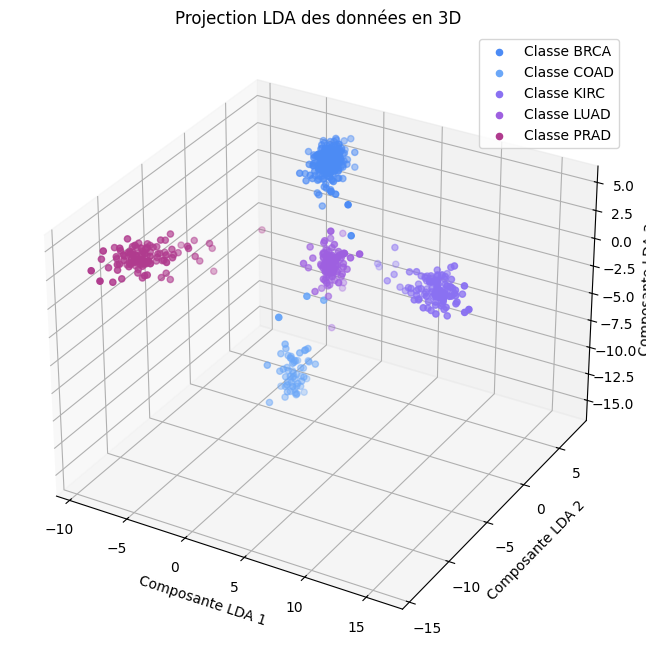

In [52]:
from mpl_toolkits.mplot3d import Axes3D

colors = ['#4C8BF5', '#6BA7F8', '#8A71F2', '#9E60E0', '#B03B8E']

# Appliquer LDA
lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X_train, y_train)

# Sélectionner les 3 premières composantes LDA
X_lda_3d = X_lda[:, :3]

# Affichage en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Pour chaque classe, on applique une couleur spécifique
for i, label in enumerate(np.unique(y_train)):
    ax.scatter(X_lda_3d[y_train.ravel() == label, 0], 
               X_lda_3d[y_train.ravel() == label, 1], 
               X_lda_3d[y_train.ravel() == label, 2], 
               label=f'Classe {label}', 
               color=colors[i % len(colors)])  # Associer la couleur à la classe

ax.set_xlabel('Composante LDA 1')
ax.set_ylabel('Composante LDA 2')
ax.set_zlabel('Composante LDA 3')
ax.set_title('Projection LDA des données en 3D')
ax.legend()
plt.show()


En voici une autre pour deux axes :

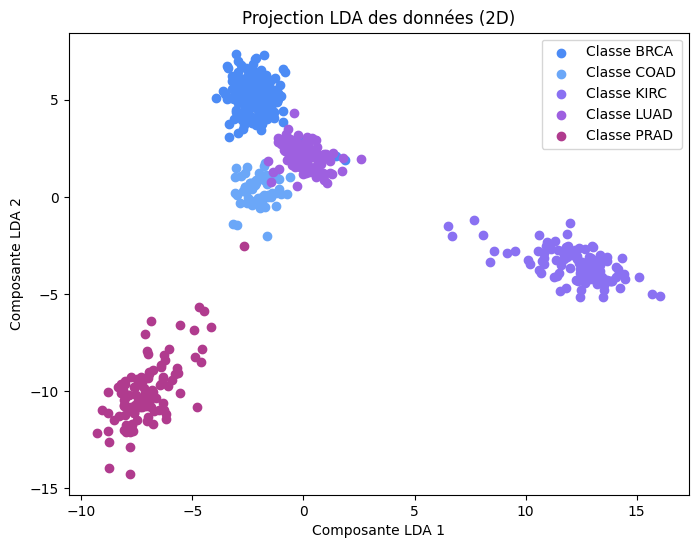

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Appliquer LDA
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_train, y_train)

colors = ['#4C8BF5', '#6BA7F8', '#8A71F2', '#9E60E0', '#B03B8E']

# Sélectionner les 2 premières composantes LDA
X_lda_2d = X_lda[:, :2]

# Affichage
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_lda_2d[y_train == label, 0], X_lda_2d[y_train == label, 1], 
                label=f'Classe {label}', color=colors[i % len(colors)])

plt.xlabel("Composante LDA 1")
plt.ylabel("Composante LDA 2")
plt.legend()
plt.title("Projection LDA des données (2D)")
plt.show()


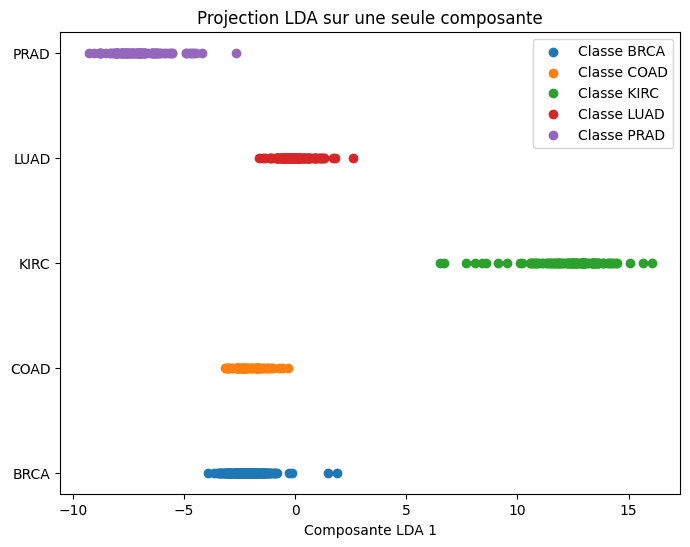

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# Appliquer LDA pour réduire à une composante
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_train, y_train)

# Visualisation
plt.figure(figsize=(8, 6))

# Scatter plot sur la première composante LDA
for label in np.unique(y_train):
    plt.scatter(X_lda[y_train == label], [label] * sum(y_train == label), label=f'Classe {label}')

plt.xlabel("Composante LDA 1")
plt.yticks(np.unique(y_train))  # Placer les classes sur l'axe des ordonnées
plt.title("Projection LDA sur une seule composante")
plt.legend()
plt.show()


# Dernières visualisation de la CV

In [60]:
# validation croisée
lda = LinearDiscriminantAnalysis(n_components=1)
cv_scores = cross_val_score(lda, X_train, y_train, cv=5)

# moyenne et l'écart-type des scores
print(f"Score moyen : {cv_scores.mean():.4f}")
print(f"Écart-type : {cv_scores.std():.4f}")


Score moyen : 0.9984
Écart-type : 0.0031
